In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import GridSearchCV
import optuna
from optuna.trial import Trial
from optuna.samplers import TPESampler
# import warnings
# warnings.filterwarnings('ignore')

In [2]:
# Data Loading
X_model = pd.read_csv('X_model.csv')
Y_model = pd.read_csv('Y_model.csv')
# Define preprocessors
def preprocess(X: pd.DataFrame):
    X = X.fillna(0)
    # Create new dataframe from columns "gender", "age_code", and "region_code"
    X_new = pd.DataFrame(X, columns=['gender', 'age_code', 'region_code'])
    GIT_range = r"202205[0-9]{2}"
    cGIT = np.sum(X.filter(regex=("c" + GIT_range), axis=1).values, axis=1)
    tGIT = np.sum(X.filter(regex=("t" + GIT_range), axis=1).values, axis=1)
    sGIT = np.sum(X.filter(regex=("s" + GIT_range), axis=1).values, axis=1)

    VAT_range = r"20220[17](?:[01][0-9]|2[0-5])"
    tVAT = np.sum(X.filter(regex=("t" + VAT_range), axis=1).values, axis=1)
    sVAT = np.sum(X.filter(regex=("s" + VAT_range), axis=1).values, axis=1)

    entire_range = r"2022[0-9]{4}"
    cEntire = np.sum(X.filter(regex=("c" + entire_range), axis=1).values, axis=1)
    tEntire = np.sum(X.filter(regex=("t" + entire_range), axis=1).values, axis=1)
    sEntire = np.sum(X.filter(regex=("s" + entire_range), axis=1).values, axis=1)

    rcGIT = np.divide(cGIT, cEntire)
    rtGIT = np.divide(tGIT, tEntire)
    rsGIT = np.divide(sGIT, sEntire)

    rtVAT = np.divide(tVAT, tEntire)
    rsVAT = np.divide(sVAT, sEntire)

    X_new['cGIT'] = cGIT
    X_new['tGIT'] = tGIT
    X_new['sGIT'] = sGIT

    X_new['tVAT'] = tVAT
    X_new['sVAT'] = sVAT

    X_new['cEntire'] = cEntire
    X_new['tEntire'] = tEntire
    X_new['sEntire'] = sEntire

    X_new['rcGIT'] = rcGIT
    X_new['rtGIT'] = rtGIT
    X_new['rsGIT'] = rsGIT

    X_new['rtVAT'] = rtVAT
    X_new['rsVAT'] = rsVAT

    X_new = X_new.fillna(0)
    print(X_new.head())

    return X_new
# Preprocess
X_model = preprocess(X_model)

C:\Users\htw06\AppData\Local\Temp\ipykernel_13920\1325921788.py:23: RuntimeWarning: invalid value encountered in true_divide
  rcGIT = np.divide(cGIT, cEntire)
C:\Users\htw06\AppData\Local\Temp\ipykernel_13920\1325921788.py:24: RuntimeWarning: invalid value encountered in true_divide
  rtGIT = np.divide(tGIT, tEntire)
C:\Users\htw06\AppData\Local\Temp\ipykernel_13920\1325921788.py:25: RuntimeWarning: invalid value encountered in true_divide
  rsGIT = np.divide(sGIT, sEntire)
C:\Users\htw06\AppData\Local\Temp\ipykernel_13920\1325921788.py:27: RuntimeWarning: invalid value encountered in true_divide
  rtVAT = np.divide(tVAT, tEntire)
C:\Users\htw06\AppData\Local\Temp\ipykernel_13920\1325921788.py:28: RuntimeWarning: invalid value encountered in true_divide
  rsVAT = np.divide(sVAT, sEntire)


   gender  age_code  region_code  cGIT  tGIT    sGIT  tVAT    sVAT  cEntire  \
0       1        13            7   0.0   0.0     0.0   0.0     0.0      1.0   
1       1         5            1   2.0   0.0    17.0   0.0   185.0     39.0   
2       2         6            2   6.0   3.0  2253.0   0.0  1712.0     26.0   
3       2         1            1   2.0   0.0   342.0   0.0     0.0      5.0   
4       2         5            1   2.0   0.0   273.0   0.0   104.0     10.0   

   tEntire  sEntire     rcGIT  rtGIT     rsGIT  rtVAT     rsVAT  
0      1.0     93.0  0.000000    0.0  0.000000    0.0  0.000000  
1      0.0    790.0  0.051282    0.0  0.021519    0.0  0.234177  
2      3.0   5119.0  0.230769    1.0  0.440125    0.0  0.334440  
3      0.0    647.0  0.400000    0.0  0.528594    0.0  0.000000  
4      1.0    608.0  0.200000    0.0  0.449013    0.0  0.171053  


In [6]:
# ensemble = RandomForestClassifier(
#     criterion = "gini", ## {"gini","entropy","log_loss"}
#     n_estimators = 50, ##default
#     max_depth = study.best_params['max_depth'], ##default
#     min_samples_split = study.best_params['min_samples_split'], 
#     min_samples_leaf = study.best_params['min_samples_leaf'],
#     min_weight_fraction_leaf = study.best_params['min_weight_fraction_leaf'],
#     max_features = "sqrt", ##default
#     max_leaf_nodes = None, #default
#     min_impurity_decrease = 0.0, #default
#     random_state = 100,
#     class_weight = "balanced"
# )
def RF_objective(trial):
    max_depth = trial.suggest_int('max_depth', 10,20) # 10
    max_leaf_nodes = trial.suggest_int('max_leaf_nodes', 2, 8) #6
    n_estimators =  100
#     min_samples_split = trial.suggest_int('min_samples_split',1,12),
#     min_samples_leaf = trial.suggest_int('min_samples_leaf',1,10),
#     min_impurity_decrease = trial.suggest_float('min_impurity_decrease', 0.0, 0.5),
   
    model = RandomForestClassifier(max_depth = max_depth, 
                                   max_leaf_nodes = max_leaf_nodes,
                                   n_estimators = n_estimators,
                                   n_jobs=2,random_state=25,
                                   class_weight = "balanced"
                                  )
 
    score = cross_val_score(model, X_model, Y_model, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=100),
                            scoring="roc_auc")
    
    return score.mean()
    
#Execute optuna and set hyperparameters
optuna.logging.set_verbosity(optuna.logging.WARNING)
RF_study = optuna.create_study(direction='maximize')
RF_study.optimize(RF_objective, show_progress_bar=True, n_trials=3)

# Print the best parameters
print(RF_study.best_params)

C:\Users\htw06\Anaconda3\lib\site-packages\optuna\progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\htw06\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\htw06\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\htw06\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\htw06\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y wa

{'max_depth': 10, 'max_leaf_nodes': 6}


C:\Users\htw06\AppData\Local\Temp\ipykernel_13920\1770773629.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  optimized_RF.fit(X_model,Y_model)
C:\Users\htw06\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\htw06\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\htw06\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was exp

Average ROC AUC Score 0.8436927492294904
Standard Deviation of ROC AUC Score 0.0014508761666405206
[0.84399497 0.84413129 0.84155455 0.84592334 0.84285959]


<BarContainer object of 5 artists>

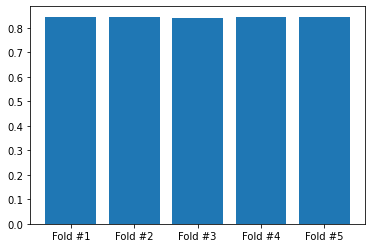

In [8]:
#Create an instance with tuned hyperparameters
optimized_RF = RandomForestClassifier(max_depth = RF_study.best_params['max_depth'],
                                      max_leaf_nodes = RF_study.best_params['max_leaf_nodes'],
                                      n_estimators = 100,n_jobs=2,random_state=25)
optimized_RF.fit(X_model,Y_model)

scores = cross_val_score(
    optimized_RF, 
    X_model, 
    Y_model, 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=25),
    scoring='roc_auc'
)
print("Average ROC AUC Score", np.mean(scores))
print("Standard Deviation of ROC AUC Score", np.std(scores))
# Plot 5 scores in bar plot
print(scores)
plt.bar(list(map(lambda i: f"Fold #{i}", range(1, 6))), scores)